In this note I study an imbalanced classification problem and show how oversampling with **SMOTE** improves the performance.

The dataset can be found in the following link:
https://archive.ics.uci.edu/ml/datasets.php?format=&task=cla&att=&area=&numAtt=&numIns=&type=&sort=nameUp&view=table

## Overview

* Data visualization
* Separating numerical and categorical data
* Filling the missing values
* One-hot encoding
* Training different models
* Over-sampling
* Hypertune parameters


In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import cross_val_score

from sklearn.metrics import confusion_matrix , f1_score , recall_score , precision_score
from sklearn.model_selection import train_test_split

#### Data overview

To understand each data information and name of columns, use the following cell

In [4]:
file = open("1 breast cancer/breast-cancer.names", "r") 
print(file.read())

Citation Request:
   This breast cancer domain was obtained from the University Medical Centre,
   Institute of Oncology, Ljubljana, Yugoslavia.  Thanks go to M. Zwitter and 
   M. Soklic for providing the data.  Please include this citation if you plan
   to use this database.

1. Title: Breast cancer data (Michalski has used this)

2. Sources: 
   -- Matjaz Zwitter & Milan Soklic (physicians)
      Institute of Oncology 
      University Medical Center
      Ljubljana, Yugoslavia
   -- Donors: Ming Tan and Jeff Schlimmer (Jeffrey.Schlimmer@a.gp.cs.cmu.edu)
   -- Date: 11 July 1988

3. Past Usage: (Several: here are some)
     -- Michalski,R.S., Mozetic,I., Hong,J., & Lavrac,N. (1986). The 
        Multi-Purpose Incremental Learning System AQ15 and its Testing 
        Application to Three Medical Domains.  In Proceedings of the 
        Fifth National Conference on Artificial Intelligence, 1041-1045,
        Philadelphia, PA: Morgan Kaufmann.
        -- accuracy range: 66%-72%
     -

In [8]:
col_name = ['Class','age','menopause','tumor-size','inv-nodes','node-caps','deg-malig','breast','breast-quad','irradiat']
data1 = pd.read_csv('1 breast cancer/breast-cancer.data', sep=',' , header=None , names=col_name )
data1.head()


,Class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no


In [9]:
print('number of  (data, features) in dataset 1 is', data1.shape)

number of  (data, features) in dataset 1 is (286, 10)


In [10]:
data1.dtypes

Class          object
age            object
menopause      object
tumor-size     object
inv-nodes      object
node-caps      object
deg-malig       int64
breast         object
breast-quad    object
irradiat       object
dtype: object

* We have 9 features and the 'Class' column as the target.
* There are 286 data with 9 missing values (1 in breast-quad and 8 in node-caps). The missing values are labled with '?'
* Columns 'age', 'Tumor-size', 'inv-nodes', 'deg-malig' are numerical and the rest are categorical.

Lets take a look into the 'Class' column

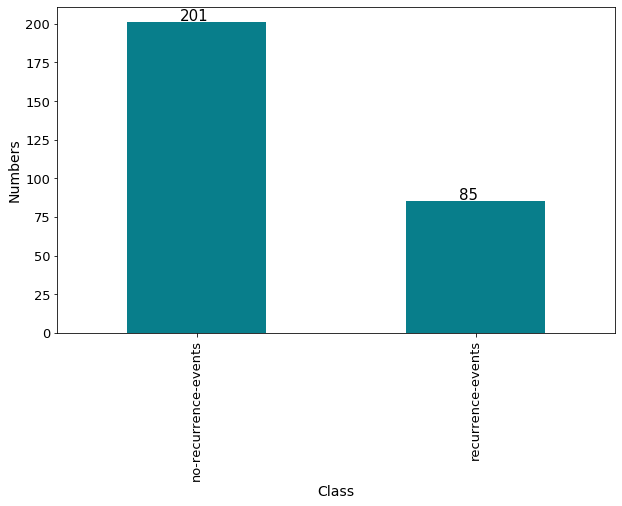

In [11]:
ax = data1['Class'].value_counts().plot(kind='bar', figsize=(10, 6), fontsize=13, color='#087E8B')
ax.set_ylabel('Numbers', fontsize=14)
ax.set_xlabel('Class', fontsize=14)

for i in ax.patches:
    ax.text(i.get_x() + 0.19, i.get_height() + 1, str(round(i.get_height(), 2)), fontsize=15)

There are 201 no-re. data and 85 rec. data which makes our dataset **imbalanced**

(Note: It is not highly imbalanced, but it is Okay for our purpose of working with over-sampling technique)

#### Separating numerical data from categorical

In [12]:
data=data1
col_name=['age','tumor-size','inv-nodes']
for col in col_name:
    data[col] = pd.Categorical(data[col])
    data[col] = data[col].cat.codes
data.dtypes

Class          object
age              int8
menopause      object
tumor-size       int8
inv-nodes        int8
node-caps      object
deg-malig       int64
breast         object
breast-quad    object
irradiat       object
dtype: object

In [13]:
data.describe()

,age,tumor-size,inv-nodes,deg-malig
count,286.000000,286.000000,286.000000,286.000000
mean,2.664336,4.062937,1.073427,2.048951
std,1.011818,2.151187,1.935321,0.738217
min,0.000000,0.000000,0.000000,1.000000
25%,2.000000,3.000000,0.000000,2.000000
50%,3.000000,4.000000,0.000000,2.000000
75%,3.000000,5.000000,1.000000,3.000000
max,5.000000,10.000000,6.000000,3.000000


#### Filling missing values

In [14]:
col_name=['node-caps','breast-quad']
for col in col_name:
    print(col,'number of categories:',data[col].nunique())
    print(data[col].value_counts())

node-caps number of categories: 3
no     222
yes     56
?        8
Name: node-caps, dtype: int64
breast-quad number of categories: 6
left_low     110
left_up       97
right_up      33
right_low     24
central       21
?              1
Name: breast-quad, dtype: int64


The '?' values are missing values. We can do the followings to them:

     * Skip the features (not recommended)
     * skip the data (not bad as they are just a few)
     * make a new category (not recommended as we know they are not a separate category)
     * fill them with mode (good idea)
     * predict them based on the rest of data

Here, I only fill the with mode (put them in the category with highest probability). I expect that these values does not effect the performance of algorithm that much as they are only 9 in total.

In [15]:
data['node-caps']=data['node-caps'].str.replace('?','no')
data['breast-quad']=data['breast-quad'].str.replace('?','left_low')
for col in col_name:
    print(data[col].value_counts())

no     230
yes     56
Name: node-caps, dtype: int64
left_low     111
left_up       97
right_up      33
right_low     24
central       21
Name: breast-quad, dtype: int64


#### Categorical features: One-hot encoding

Now, there is no missing values in our dataset, so I can deal with non-numerical features. I apply the one-hot encoding to deal with all categories with the same weight

In [16]:
data['Class'] = pd.Categorical(data['Class'])
data['Class'] = data['Class'].cat.codes
y=data['Class']

X=data.drop('Class',axis=1,inplace=False)

col_name=['menopause','node-caps','breast','breast-quad','irradiat']
for col in col_name:
    X = pd.get_dummies(X, columns = [col])

In [17]:
X.head()

,age,tumor-size,inv-nodes,deg-malig,menopause_ge40,menopause_lt40,menopause_premeno,node-caps_no,node-caps_yes,breast_left,breast_right,breast-quad_central,breast-quad_left_low,breast-quad_left_up,breast-quad_right_low,breast-quad_right_up,irradiat_no,irradiat_yes
0,1,5,0,3,0,0,1,1,0,1,0,0,1,0,0,0,1,0
1,2,3,0,2,0,0,1,1,0,0,1,0,0,0,0,1,1,0
2,2,3,0,2,0,0,1,1,0,1,0,0,1,0,0,0,1,0
3,4,2,0,2,1,0,0,1,0,0,1,0,0,1,0,0,1,0
4,2,0,0,2,0,0,1,1,0,0,1,0,0,0,1,0,1,0


The data is normalized itself and do not need scaling. So now I train some models

#### Training models

Choose of **metric**: This problem is an imbalanced classification. So it is important not to only have a high accuracy in the prediction, but also not to miss any negative result (high recall). To have both high precision and recall, I use the **f-score** as the metric

In [20]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=1)

clf = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=1, min_samples_split=2,  max_features=2)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_valid)

print('RandomForest')
print('F-score=', f1_score(y_valid, y_pred))
print('Recall=', recall_score(y_valid, y_pred))
print('Precision=', precision_score(y_valid, y_pred))

clf = tree.DecisionTreeClassifier(random_state=0, max_depth=3, min_samples_leaf=5, min_samples_split=5)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_valid)

print('Decision Tree')
print('F-score=', f1_score(y_valid, y_pred))
print('Recall=', recall_score(y_valid, y_pred))
print('Precision=', precision_score(y_valid, y_pred))

clf = svm.SVC(kernel='linear', C=1, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_valid)

print('SVC')
print('F-score=', f1_score(y_valid, y_pred))
print('Recall=', recall_score(y_valid, y_pred))
print('Precision=', precision_score(y_valid, y_pred))

clf = KNeighborsClassifier(n_neighbors = 10 , weights='distance')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_valid)

print('KNN')
print('F-score=', f1_score(y_valid, y_pred))
print('Recall=', recall_score(y_valid, y_pred))
print('Precision=', precision_score(y_valid, y_pred))

clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_valid)

print('GNB')
print('F-score=', f1_score(y_valid, y_pred))
print('Recall=', recall_score(y_valid, y_pred))
print('Precision=', precision_score(y_valid, y_pred))

RandomForest
F-score= 0.4166666666666667
Recall= 0.2777777777777778
Precision= 0.8333333333333334
Decision Tree
F-score= 0.3448275862068966
Recall= 0.2777777777777778
Precision= 0.45454545454545453
SVC
F-score= 0.375
Recall= 0.3333333333333333
Precision= 0.42857142857142855
KNN
F-score= 0.3703703703703704
Recall= 0.2777777777777778
Precision= 0.5555555555555556
GNB
F-score= 0.5238095238095238
Recall= 0.6111111111111112
Precision= 0.4583333333333333


The maximum F-score belongs to GNB. This method is usually good for the imbalanced data, however it gives a low precision. The next best method is the random Forest. I will proceed with this method as it has a very good precision and show how we can improve the recall with it.

First, Lets tune the parameters of model. To do this, we can use the grid search, but to have some visualization I take the plot of F-score for different parameters of the model:

Text(0.5, 1.0, 'Test of Different Parameters')

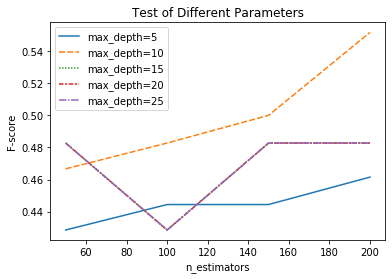

In [21]:

# function
def BuildValidModel(n_esti, max_depth):
    model = RandomForestClassifier(n_estimators=n_esti, max_depth=max_depth, random_state=1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    score=f1_score(y_valid, y_pred)
    return score

# parameters I want to test
n_esti=list(range(50,201,50))
max_depth=[5,10,15,20,25]

# run function several times and save results in a data frame
accuracy=dict()
for i in range(5):
    a=[]
    for j in range(4):
        a.append(BuildValidModel(n_esti[j],max_depth[i]))
    accuracy['max_depth='+str(max_depth[i])]=a
accu_data=pd.DataFrame(accuracy,index=n_esti)

# plot results
ax=sns.lineplot(data=accu_data)
ax.set(xlabel='n_estimators', ylabel='F-score')
plt.title('Test of Different Parameters')

So, we can choose n_estimator=200 and max-depth=10. 
Note that in this model, increasing the n_estimator always improves the performance but it might be time consuming.

In [24]:
clf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_valid)

print('RandomForest')
print('F-score=', f1_score(y_valid, y_pred))
print('Recall=', recall_score(y_valid, y_pred))
print('Precision=', precision_score(y_valid, y_pred))

RandomForest
F-score= 0.5517241379310345
Recall= 0.4444444444444444
Precision= 0.7272727272727273


To improve the recall, one can define a threshold for the probability that the model predic no-rec. or rec.. This is based on demands of the problem whether we need more recall or more precision.

In [25]:
model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=1)
model.fit(X_train, y_train)
threshold = 0.1
y_pred_prob = model.predict_proba(X_valid)
y_pred=(y_pred_prob[:,1] >= threshold).astype('int')
print('RandomForest')
print('F-score=', f1_score(y_valid, y_pred))
print('Recall=', recall_score(y_valid, y_pred))
print('Precision=', precision_score(y_valid, y_pred))

confusion_matrix(y_valid, y_pred,labels=None, sample_weight=None)

RandomForest
F-score= 0.5161290322580644
Recall= 0.8888888888888888
Precision= 0.36363636363636365


array([[12, 28],
       [ 2, 16]], dtype=int64)

#### OverSampling with SMOTE

For imbalance classification, one of the ways to improve the performance is to use Oversampling with SMOTE. (There exist other ways such as undersampling however, I do not work with them in this work due to nature of problem and lack of data)

In [28]:
from imblearn.over_sampling import SMOTE

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=1)


sm = SMOTE(random_state=42)

X_sm, y_sm = sm.fit_resample(X_train, y_train)

print(f'''Shape of X before SMOTE: {X_train.shape}
Shape of X after SMOTE: {X_sm.shape}''')
yv=y_sm.value_counts()

print('\nBalance of positive and negative classes (%):')
y_sm.value_counts(normalize=True) * 100



Shape of X before SMOTE: (228, 18)
Shape of X after SMOTE: (322, 18)

Balance of positive and negative classes (%):


1    50.0
0    50.0
Name: Class, dtype: float64

In [29]:

model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=1)
model.fit(X_sm, y_sm)
y_pred = model.predict(X_valid)
print('random forest')
print('F-score=', f1_score(y_valid, y_pred, average='macro'))
print('Recall=', recall_score(y_valid, y_pred, average='macro'))
print('Precision=', precision_score(y_valid, y_pred, average='macro'))

print(confusion_matrix(y_valid, y_pred,labels=None, sample_weight=None))

random forest
F-score= 0.7340388007054675
Recall= 0.7305555555555556
Precision= 0.7381635581061693
[[34  6]
 [ 7 11]]


As one can see, the method improves all metrics (Recall, precision, and F-score) together